In [1]:
import sys
import os

sys.path.append(os.path.abspath('..'))

import yaml
import pandas as pd
from sklearn.model_selection import train_test_split

from src.data.prepare_data import prepare_data
from src.data.utils import resample_data
from src.models.utils import train_splits
from src.models.model_selection import ClassificationThreshold
from src.models.classification import Classification
from src.visuals.pr_roc_curve import plot_roc_pr_curves
from src.models.evaluation import Evaluation

In [2]:
# read config
with open('../'+'config.yml', 'r') as file:
    config=yaml.load(file, Loader= yaml.SafeLoader)
del file

In [3]:
# load and prepare data
df = pd.read_csv('../'+config['data_loader']['path'])
df = prepare_data(df=df)
display(df.head())

# resample for imbalanced sets
df_sampled = resample_data(df=df, pos_share=0.01)

# check class distributions
print(
    df['label'].value_counts(normalize=True)
    , df_sampled['label'].value_counts(normalize=True)
    )

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,label
0,-0.260648,-0.469648,2.496266,-0.083724,0.129681,0.732898,0.519014,-0.130006,0.727159,0.637735,...,-0.110552,0.217606,-0.134794,0.165959,0.126280,-0.434824,-0.081230,-0.151045,17982.10,0
1,0.985100,-0.356045,0.558056,-0.429654,0.277140,0.428605,0.406466,-0.133118,0.347452,0.529808,...,-0.194936,-0.605761,0.079469,-0.577395,0.190090,0.296503,-0.248052,-0.064512,6531.37,0
2,-0.260272,-0.949385,1.728538,-0.457986,0.074062,1.419481,0.743511,-0.095576,-0.261297,0.690708,...,-0.005020,0.702906,0.945045,-1.154666,-0.605564,-0.312895,-0.300258,-0.244718,2513.54,0
3,-0.152152,-0.508959,1.746840,-1.090178,0.249486,1.143312,0.518269,-0.065130,-0.205698,0.575231,...,-0.146927,-0.038212,-0.214048,-1.893131,1.003963,-0.515950,-0.165316,0.048424,5384.44,0
4,-0.206820,-0.165280,1.527053,-0.448293,0.106125,0.530549,0.658849,-0.212660,1.049921,0.968046,...,-0.106984,0.729727,-0.161666,0.312561,-0.414116,1.071126,0.023712,0.419117,14278.97,0


label
0    0.5
1    0.5
Name: proportion, dtype: float64 label
0    0.99
1    0.01
Name: proportion, dtype: float64


In [4]:
# split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    df_sampled.iloc[:,:-1], df_sampled['label']
    , test_size=config['train_test_split']['test_size']
    , random_state=123
    , shuffle=True
    , stratify=df_sampled['label']
    )

# check class distributions
print(
    y_train.value_counts(normalize=True)
    , y_test.value_counts(normalize=True)
    )

label
0    0.99
1    0.01
Name: proportion, dtype: float64 label
0    0.990011
1    0.009989
Name: proportion, dtype: float64


In [5]:
# split train sets into multiple sets and check class distributions
train = train_splits(X_train, y_train, config['train_test_split'])
[train[i].iloc[:,-1].value_counts(normalize=True) for i in train.keys()]

[label
 0    0.989996
 1    0.010004
 Name: proportion, dtype: float64,
 label
 0    0.990004
 1    0.009996
 Name: proportion, dtype: float64]

0.4201511450845635


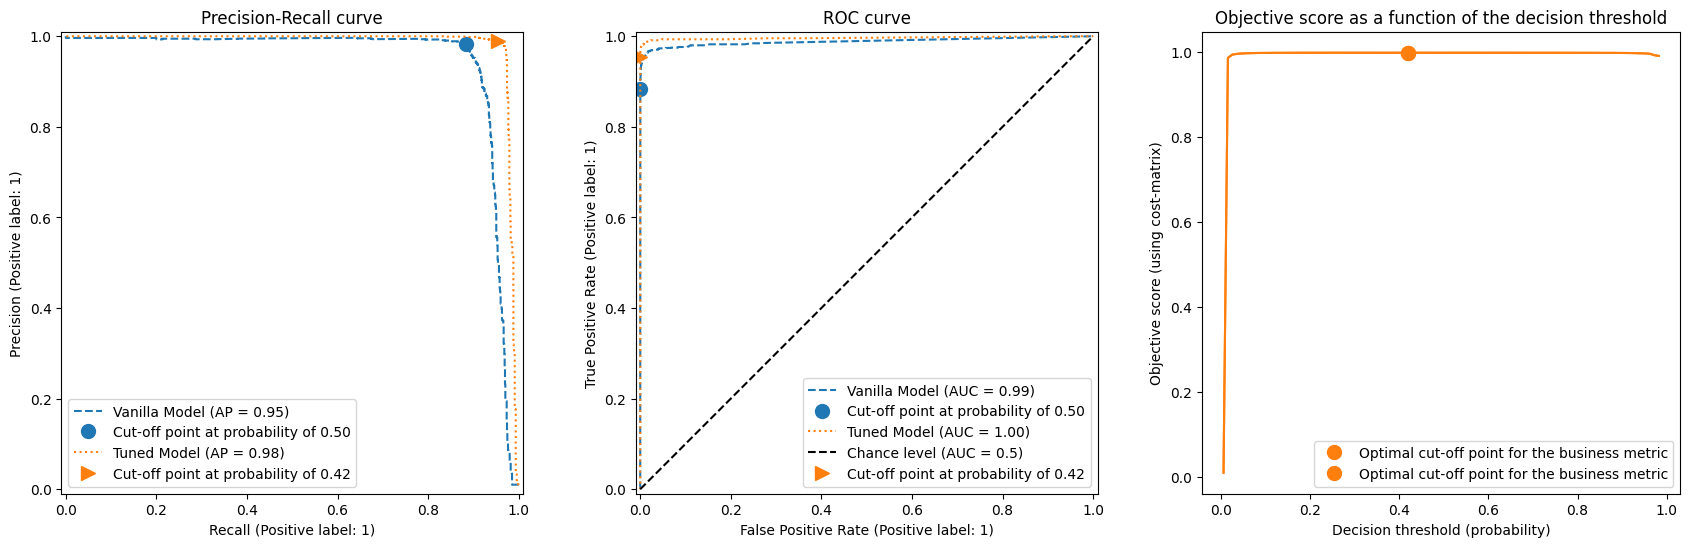

In [6]:
# fit algorithm
clf = Classification(
    algorithm='XGBClassifier'
    , **{'n_estimators': 10, 'max_depth': 20}
    )

clf.fit(X=train[1].iloc[:, :-1], y=train[1].iloc[:,-1])

# tune classification threshold
tuned_clf = ClassificationThreshold(config=config['optimization'])
tuned_clf.fit(clf=clf, X=train[2].iloc[:,:-1], y=train[2].iloc[:,-1])

threshold = tuned_clf.best_threshold
print(threshold)

plot_roc_pr_curves(clf.model, tuned_clf.model, X_train=train[2].iloc[:,:-1], y_train=train[2].iloc[:,-1])

In [7]:
# fit algorithm on whole training set
clf = Classification(
    algorithm='XGBClassifier'
    , **{'n_estimators': 10, 'max_depth': 20}
    )
clf.fit(X=X_train, y=y_train)

# test set evaluation
for i in [0.5, threshold]:
    eval = Evaluation(clf=clf, threshold=i)
    display(
        eval.fit(
            X_train=X_train, y_train=y_train
            , X_test=X_test, y_test=y_test
            )
            )

,metric,train,test
0,accuracy,0.99958,0.99909
1,precision,0.99503,1.00000
2,recall,0.96298,0.90845
3,f1_score,0.97874,0.95203
4,TP,2601.00000,129.00000
5,TN,267384.00000,14074.00000
6,FP,13.00000,0.00000
7,FN,100.00000,13.00000


,metric,train,test
0,accuracy,0.99960,0.99916
1,precision,0.99428,1.00000
2,recall,0.96557,0.91549
3,f1_score,0.97971,0.95588
4,TP,2608.00000,130.00000
5,TN,267382.00000,14074.00000
6,FP,15.00000,0.00000
7,FN,93.00000,12.00000
